In [ ]:
"""
Solar Panel Classification Project (Kaggle)

Duke University
Master's in Interdisiplinary Data Science
IDS 705 - Principles of Machine Learning
Instructor: Dr. Kyle Bradbury
    
Notes: 
This project is derived from Dr. Bradbury's kNN example, using his some of his the load_data, set_classifier, 
cv_performance_assessment, and plot_roc functions, as well as the produce_submissions conditional. 
I redid it using more sophisticate methods than my original to better understand image classification.
"""

In [1]:
# Library's and Packages to be utilized
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential                         # Used to build a sequential cNN
from keras.layers import Conv2D, MaxPooling2D, Activation   # Adding layers to the cNN
from keras.layers import Dropout, Flatten, Dense            # Connecting layers for the Conv Layers
import numpy as np                                          # Linear Algrebra
import matplotlib.pyplot as plt                             # Simple Plots
import matplotlib as mpl                                    # Matplotlib
import pandas as pd                                         # Dataframes/reading data
from sklearn.model_selection import StratifiedKFold         # Used for Validation testing
import sklearn.metrics as metrics                           # Used for calculating metrics on our model
import cv2                                                  # Used to manipulate images prior to input

plt.close()

In [2]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

In [3]:
def load_data(dir_data, dir_labels, training = True):
    ''' Load each of the image files into memory 
    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory
    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = cv2.imread(fname)
        image     = cv2.resize(image, (0,0),    # Determine image to preprocess
                              fx=1, fy=1,       # Used to resize by factor but we keep it 101,101 pixels
                              interpolation = cv2.INTER_AREA) # Antialiasing
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # Convert to RGB Scale
        image     = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    # Convert to HSV (makes anything not a solar panel green)
        image     = cv2.GaussianBlur(image, (5, 5), 0)        # removes additional noise from the dataset
        image     = image/255                                 # scales all of the values to a num between 0 an 1
        data.append(image)                                    # add the image to the array
    data = np.array(data)                                     # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [4]:
def set_classifier():
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    # initialize the classifier as a sequential
    # Basically we are building the layers of the cNN manually, and 
    # that means we are going to do them in the order that they arise
    clf = Sequential()
    

    clf.add(Conv2D(64, (3, 3), input_shape=(101, 101, 3)))  
    clf.add(Activation('elu'))                 
    clf.add(MaxPooling2D(pool_size=(2, 2)))     

    # Add the second conv. layer
    clf.add(Conv2D(64, (3, 3)))
    clf.add(Activation('elu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))

    # Add the third conv. layer
    clf.add(Conv2D(128, (3, 3)))
    clf.add(Activation('elu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convert our 3D feature maps to 1D feature vectors
    clf.add(Flatten())  
    
    # Build our hidden layer to connect all of the above layers together
    clf.add(Dense(64))                         
    clf.add(Activation('relu'))
    clf.add(Dropout(0.3))                     
    clf.add(Dense(1))                          
                                               
    clf.add(Activation('sigmoid'))
    clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])            
    
    return clf

In [5]:
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier        
        clf.fit(X_train, y_train, 
                epochs = 5)
        
        # Test the classifier on the validation data for this fold      
        cpred            = clf.predict(X_val)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,0]

    return prediction_scores

In [6]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC for cNN using Keras with Tensorflow')
    plt.tight_layout()
    plt.show()

Epoch 1/5
38/38 [==============================] - 9s 238ms/step - loss: 0.6475 - accuracy: 0.6325
Epoch 2/5
38/38 [==============================] - 9s 247ms/step - loss: 0.5757 - accuracy: 0.7108
Epoch 3/5
38/38 [==============================] - 10s 251ms/step - loss: 0.5042 - accuracy: 0.7700
Epoch 4/5
38/38 [==============================] - 9s 241ms/step - loss: 0.4241 - accuracy: 0.8108
Epoch 5/5
38/38 [==============================] - 9s 239ms/step - loss: 0.4306 - accuracy: 0.8167
Epoch 1/5
38/38 [==============================] - 9s 239ms/step - loss: 0.4010 - accuracy: 0.8200
Epoch 2/5
38/38 [==============================] - 9s 248ms/step - loss: 0.2946 - accuracy: 0.8842
Epoch 3/5
38/38 [==============================] - 10s 258ms/step - loss: 0.2675 - accuracy: 0.8825
Epoch 4/5
38/38 [==============================] - 9s 245ms/step - loss: 0.2228 - accuracy: 0.9108
Epoch 5/5
38/38 [==============================] - 9s 239ms/step - loss: 0.1530 - accuracy: 0.9383
Epoch 1/

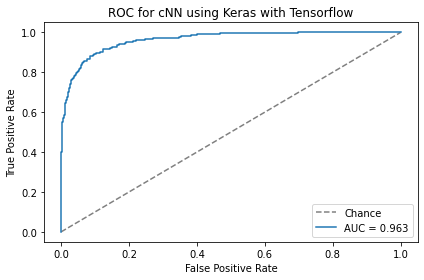

In [7]:
'''
Sample script for cross validated performance
'''

# Set parameters for the analysis
num_training_folds = 5

# Load the data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

# Choose which classifier to use
clf = set_classifier()

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(data,labels,num_training_folds,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [8]:
'''
Sample script for producing a Kaggle submission
'''

produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission:
    
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    
    # Split the training data between a training and validation set
    training_data, valid_data, training_labels, valid_labels = train_test_split(training_data ,
                                                                                training_labels, 
                                                                                test_size = 0.25, 
                                                                                random_state = 35)
    
    # Augment the data to create more images
    aug = ImageDataGenerator(rotation_range = 30,                    # Rotate original images up to 30 degrees
                             width_shift_range = 0.1,                # shift the image along the X axis up to 10%
                             height_shift_range = 0.1,               # Shift the Image along the Y Axis up to 10%
                             shear_range = 0.2,                      # Cut off edges of the image up to 20%
                             zoom_range = 0.2,                       # Zoom in on the image up to 20%
                             horizontal_flip = True,                 # Flip the image along the horizonal
                             fill_mode = "nearest")                  # fill any gaps from shearing from the nearest pixels
    
    # Train the classifier on the augmented data
    clf.fit_generator(aug.flow(training_data, training_labels, batch_size = 50), 
                      validation_data = (valid_data, valid_labels), 
                      steps_per_epoch = len(training_data), epochs = 5, verbose = 1)
    
    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training = False)
    test_scores    = clf.predict(test_data)[:,0]
    

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission.csv',
                           columns = ['id','score'],
                           index = False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
  23/1125 [..............................] - 10s 446ms/step - loss: 0.6012 - accuracy: 0.7600 - val_loss: 0.3825 - val_accuracy: 0.8533
